<a href="https://colab.research.google.com/github/anurvish/Scalable_Data/blob/main/modelLasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import normalize,StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

In [3]:
#reading the data from CSV file
df = pd.read_csv("final_data.csv", )

#Obtained preprocessed data
df = df.replace(np.NaN, 0)

#dropping columns considered as not available during movie conception stage and irrelevant columns
df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df.drop(labels=['release_date_main'],axis=1,inplace=True)
df.drop(labels=['id_main'],axis=1,inplace=True)
df.drop(labels=['runtime_main'],axis=1,inplace=True)

#Splitting the data into Independent features and target variable 
Independent_features = df.iloc[:,1:]
Target = df.iloc[:,0]
Independent_features = Independent_features.replace(np.nan,0)

In [4]:
# calculate Variance inflation factor for the given data frame
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fitb
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


In [5]:
df_vif = calculate_vif(Independent_features,['budget_main','Action_genre_main',
       'Adventure_genre_main', 'Animation_genre_main', 'Comedy_genre_main',
       'Crime_genre_main', 'Documentary_genre_main', 'Drama_genre_main',
       'Family_genre_main', 'Fantasy_genre_main', 'History_genre_main',
       'Horror_genre_main', 'Music_genre_main', 'Mystery_genre_main',
       'Romance_genre_main', 'Science Fiction_genre_main',
       'TV Movie_genre_main', 'Thriller_genre_main', 'War_genre_main',
       'Western_genre_main', 'collection_popularity_coll_details','popularity_crew', '0_gender_crew', '1_gender_crew',
       '2_gender_crew','Directing_relevance_crew', 'popularity_crew_2',
       '0_gender_crew_2', '1_gender_crew_2', '2_gender_crew_2','Directing_relevance_crew_2', 'popularity_crew_3',
       '0_gender_crew_3', '1_gender_crew_3', '2_gender_crew_3','Directing_relevance_crew_3', 'popularity_cast',
       '2_gender_cast', '1_gender_cast', '0_gender_cast', '3_gender_cast',
       'Acting_relevance_cast', 'popularity_cast_2', '2_gender_cast_2',
       '1_gender_cast_2', '0_gender_cast_2', '3_gender_cast_2',
       'Acting_relevance_cast_2', 'popularity_cast_3', '2_gender_cast_3',
       '1_gender_cast_3', '0_gender_cast_3', '3_gender_cast_3',
       'Acting_relevance_cast_3', 'popularity_cast_4', '2_gender_cast_4',
       '1_gender_cast_4', '0_gender_cast_4', '3_gender_cast_4',
       'Acting_relevance_cast_4', 'popularity_cast_5', '2_gender_cast_5',
       '1_gender_cast_5', '0_gender_cast_5', '3_gender_cast_5',
       'Acting_relevance_cast_5'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as ap

In [6]:
Independent_features = Independent_features[['budget_main','Action_genre_main',
       'Adventure_genre_main', 'Animation_genre_main', 'Comedy_genre_main',
       'Crime_genre_main', 'Documentary_genre_main', 'Drama_genre_main',
       'Family_genre_main', 'Fantasy_genre_main', 'History_genre_main',
       'Horror_genre_main', 'Music_genre_main', 'Mystery_genre_main',
       'Romance_genre_main', 'Science Fiction_genre_main',
       'TV Movie_genre_main', 'Thriller_genre_main', 'War_genre_main',
       'Western_genre_main', 'collection_popularity_coll_details','popularity_crew', 'popularity_crew_2', 'popularity_crew_3', 'popularity_cast', 
       'popularity_cast_2', 'popularity_cast_3', 'popularity_cast_4', 'popularity_cast_5']]

In [7]:
#Scaling budget and revenue columns
mms_budget = MinMaxScaler()
mms_budget.fit(Independent_features['budget_main'].to_numpy().reshape(-1,1))
Independent_features['budget_main'] = mms_budget.fit_transform(Independent_features['budget_main'].to_numpy().reshape(-1,1))

mms_revenue = MinMaxScaler()
mms_revenue.fit(Target.values.reshape(-1,1))
Target = mms_revenue.fit_transform(Target.values.reshape(-1,1))

In [8]:
#splitting the final data into train and test data 
xtrain, xtest, ytrain, ytest = train_test_split(Independent_features, Target, test_size=0.2)

In [9]:
C_para = [0.1, 1, 50, 100, 500, 1000, 5000, 10000]
#C_para = [0.001, 0.005, 0.01, 0.05, 0.08, 0.1]
alpha_para = [1/(2*C) for C in C_para]
model_list = [Lasso(alpha=alpha) for alpha in alpha_para]

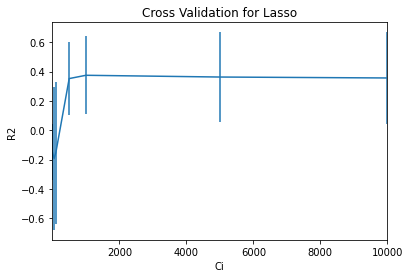

In [18]:
#ploting the mean and standard daviation value for Lasso Regression
mean_error_R2=[]; std_error_R2=[]; mean_error_RMSE=[]; std_error_RMSE=[]
for model in model_list:
  temp_R2=[];temp_RMSE = []
  kf = KFold(n_splits=5)
  for train, test in kf.split(xtrain):
    model.fit(Independent_features.iloc[train], Target[train])
    ypred = model.predict(Independent_features.iloc[test])
    temp_RMSE.append(mean_squared_error(Target[test],ypred))
    temp_R2.append(r2_score(Target[test],ypred))
  mean_error_R2.append(np.array(temp_R2).mean())
  std_error_R2.append(np.array(temp_R2).std())
  mean_error_RMSE.append(np.array(temp_RMSE).mean())
  std_error_RMSE.append(np.array(temp_RMSE).std())

plt.errorbar(C_para,mean_error_R2,yerr=std_error_R2)
plt.xlabel('Ci'); plt.ylabel('R2')
plt.xlim((0.1,10000))
plt.title('Cross Validation for Lasso')
plt.show()

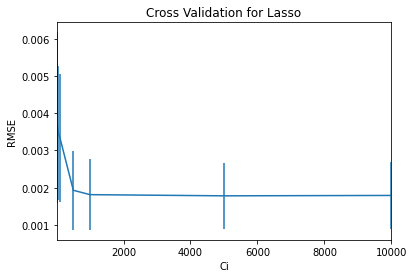

In [13]:
#ploting the mean and standard daviation value for Ridge Regression RMSE
plt.errorbar(C_para,mean_error_RMSE,yerr=std_error_RMSE)
plt.xlabel('Ci'); plt.ylabel('RMSE')
plt.xlim((0.1,10000))
plt.title('Cross Validation for Lasso')
plt.show()

In [17]:
#Training Ridge model with optimal c value for predictions
model = Lasso(alpha=1/(2*1000)).fit(xtrain,ytrain)
print('Test R2 score: ' + str(r2_score(ytest,model.predict(xtest))))
print('Test RMSE score: ' + str(mean_squared_error(ytest,model.predict(xtest),squared=False)))

Test R2 score: 0.5346175305576186
Test RMSE score: 0.04321698966316304
